# Network Intrusion Detection with Deep Learning

In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,4" #model will be trained on GPU 0

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## The Data

# New Section

In [0]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)

In [0]:
my_file =  '10data2.npy'
train,test,y_train,y_test,ylabel_train, ylabel_test = load_matrices(my_file)

## The Model

In [0]:
from keras import backend as K
from keras.layers import Input,Dense, Activation, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import InputLayer, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [0]:
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

In [0]:
# We apply a fairly simple MLP architecture

In [0]:
#actvation leakyrelu
LR= LeakyReLU(0.01)
LR.__name__ = 'lrelu'
#actvation prelu
#PR= PReLU(init='zero', weights=None)
#PR.__name__ = 'prelu'

In [0]:

filepath="./logtalos/best1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
# first we have to make sure to input data and params into the function
# add input parameters to the function
def dnn(x_train, ylabel_train, x_val, y_val, params):

    input_dim = x_train.shape[1]

    input_img = Input(shape=(input_dim,))
    
    first_neuron=params['first_neuron']
    batch_size=params['batch_size']
    kernel_initial=params['kernel_initializer']
    lr=params['lr']
    activation=params['activation']
    
    print('activation=',activation)
    
    log_file1 = './logtalos/best1/best1.hdf'
    checkpoint2 = ModelCheckpoint(log_file1, monitor='acc', save_best_only=True, mode='max')

    
    log_file2 = './logtalos/best1/best1.csv'

    csv_logger2 = CSVLogger(log_file2,separator=',', append=False)
    callbacks_list2 = [checkpoint2,csv_logger2]
    
    ###AE
    
    # replace the hyperparameter inputs with references to params dictionary 
    autoencoder = Sequential()
    #encoder
    
    if activation==PReLU: 
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        
                   
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
        
    else:
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), activation=activation, kernel_initializer=kernel_initial))
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
    
    #model = multi_gpu_model(model, gpus=1)
    autoencoder.summary()
    print(input_dim)
    
    input_img = Input(shape=(input_dim,))
    encoder_layer1 = autoencoder.layers[0]
   
    encoder = Model(input_img, encoder_layer1(input_img))
    
    #encoder_layer1 = autoencoder.layers[0]
    #encoder_layer2 = autoencoder.layers[1]
    #encoder_layer3 = autoencoder.layers[2]
    #encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
    encoder.summary()

    
    autoencoder.compile(loss='mse', optimizer='adam', metrics=['acc'])
    #model.compile(loss=params['losses'],
    #              optimizer=params['optimizer'](),
    #              metrics=['acc', fmeasure_acc])
    
   

    
    history=autoencoder.fit(x,x,
                             epochs=params['epochs'],
                             batch_size=batch_size,
                              #shuffle=True,
                              #validation_split=0,
                              callbacks=callbacks_list,                    
                             #callbacks=[early_stopping])
                              validation_data=(test,test),
                              verbose=1)
  

    num_classes=15
    out2 = Dense(num_classes, activation='softmax',kernel_initializer=kernel_initial)(encoder.output)
    newmodel = Model(encoder.input,out2)
    
   
    newmodel.compile(loss='categorical_crossentropy', 
                     #optimizer='adam', 
                     optimizer= Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False),
                     metrics=['acc']) 
    newmodel.summary()


    history2a=newmodel.fit(x, y,
                           epochs=params['epochs2'],
                           batch_size=batch_size,
                           #validation_split=0,
                           callbacks=callbacks_list2,
                           #callbacks=[early_stopping],
                           validation_data=(test,ylabel_test),
                           verbose=1)

    
    del encoder
    del autoencoder
    #del dnn_model
    
    tf.reset_default_graph()
    
    return history2a, newmodel #, encoder
    

In [0]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[60],
     'batch_size': [32],
     'epochs': [20],
     'epochs2': [200],
     'dropout': [0],
     'kernel_initializer': ['lecun_normal'],
     'optimizer': [Adam],
     'lr':[0.001],
     'activation':[relu]}


In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, clear_session

config = tf.ConfigProto(allow_soft_placement=True)
#config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [0]:
x=train
y=ylabel_train

In [0]:
np.shape(x)

(1619315, 80)

In [0]:
np.shape(y)

(1619315, 15)

In [27]:
t = ta.Scan(x, y, p, dnn, experiment_no='11')#,grid_downsample=0.1,)


  0%|          | 0/1 [00:00<?, ?it/s]

activation= <function relu at 0x7fa35de459d8>
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                4880      
Total params: 9,740
Trainable params: 9,740
Non-trainable params: 0
_________________________________________________________________
80
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                4860      
Total params: 4,860
Trainable params: 4,860
No

In [28]:
from keras.models import load_model
filepath2='./logtalos/best1/best1.hdf'
dnn=load_model(filepath2)
print(dnn.summary())
dnn.load_weights(filepath2)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = dnn.evaluate(test, ylabel_test, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                915       
Total params: 5,775
Trainable params: 5,775
Non-trainable params: 0
_________________________________________________________________
None
Created model and loaded weights from file
acc: 95.70%


In [29]:


result_train = dnn.evaluate(train,ylabel_train)
for name, value in zip(dnn.metrics_names, result_train):
    print(name, value)
    
print("%s: %.2f%%" % (dnn.metrics_names[1], result_train[1]*100))

##prediksi data Train

preds = dnn.predict(train)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(ylabel_train, axis=1)

1619315/1619315 [==============================] - 28s 18us/step
loss 0.12557761152540184
acc 0.9567588764385309
acc: 95.68%


In [0]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:

from sklearn.metrics import classification_report
outcomes = ['Benign', 'Bot', 'Brute Force -Web', 'Brute Force -XSS',
'DDOS attack-HOIC','DDOS attack-LOIC-UDP','DDoS attacks-LOIC-HTTP',
'DoS attacks-GoldenEye','DoS attacks-Hulk','DoS attacks-SlowHTTPTest','DoS attacks-Slowloris',
'FTP-BruteForce','Infilteration','SQL Injection','SSH-Bruteforce' ]
class_names=outcomes


target_names = ["Class {}".format(i) for i in range(15)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

                          precision    recall  f1-score   support

                  Benign    0.95427   0.99527   0.97434    803025
                     Bot    0.99963   0.99973   0.99968     85842
        Brute Force -Web    0.80500   0.64919   0.71875       496
        Brute Force -XSS    0.97849   0.48663   0.65000       187
        DDOS attack-HOIC    0.99994   0.99999   0.99997    192098
    DDOS attack-LOIC-UDP    0.90612   0.95668   0.93071      1362
  DDoS attacks-LOIC-HTTP    0.99903   0.99877   0.99890    161447
   DoS attacks-GoldenEye    0.99840   0.99952   0.99896     25008
        DoS attacks-Hulk    0.99989   0.99978   0.99984    138459
DoS attacks-SlowHTTPTest    0.77124   0.48964   0.59899     41974
   DoS attacks-Slowloris    0.99533   0.99924   0.99728      6612
          FTP-BruteForce    0.70799   0.89510   0.79062     58055
           Infilteration    0.73773   0.21294   0.33049     48347
           SQL Injection    0.51064   0.33803   0.40678        71
         

Confusion matrix, without normalization
[[799228     31     11      0     11      0     23     10      5      3
      25      2   3657     14      5]
 [    22  85819      0      0      0      0      0      0      0      0
       0      0      1      0      0]
 [   134      0    322      2      0      0     33      0      0      0
       0      0      0      5      0]
 [    15      0     47     91      0      0     34      0      0      0
       0      0      0      0      0]
 [     1      0      0      0 192097      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0   1303     59      0      0      0
       0      0      0      0      0]
 [    64      0      0      0      0    135 161248      0      0      0
       0      0      0      0      0]
 [     2      0      0      0      0      0      0  24996      6      0
       4      0      0      0      0]
 [     1      0      0      0      0      0      0     28 138429      0
       0

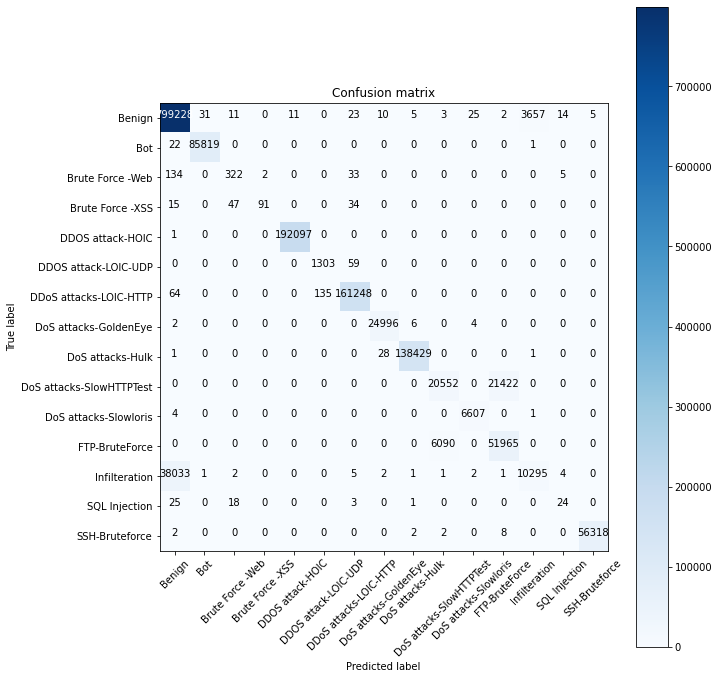

In [32]:


#outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))

# Data Test

In [33]:

#Data Test
result_test = dnn.evaluate(test,ylabel_test)
for name, value in zip(dnn.metrics_names, result_test):
    print(name, value)
    
print("%s: %.2f%%" % (dnn.metrics_names[1], result_test[1]*100))


404836/404836 [==============================] - 7s 17us/step
loss 0.12590469080661634
acc 0.9569825806005394
acc: 95.70%


In [0]:

##prediksi data Train
#y_test=y_test.to_numpy()

preds = dnn.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(ylabel_test, axis=1)



                          precision    recall  f1-score   support

                  Benign    0.95511   0.99487   0.97458    201238
                     Bot    0.99949   0.99967   0.99958     21479
        Brute Force -Web    0.78889   0.61739   0.69268       115
        Brute Force -XSS    1.00000   0.48837   0.65625        43
        DDOS attack-HOIC    0.99998   0.99998   0.99998     48006
    DDOS attack-LOIC-UDP    0.87500   0.95109   0.91146       368
  DDoS attacks-LOIC-HTTP    0.99886   0.99831   0.99858     40219
   DoS attacks-GoldenEye    0.99788   0.99918   0.99853      6123
        DoS attacks-Hulk    0.99980   0.99974   0.99977     34758
DoS attacks-SlowHTTPTest    0.77048   0.49246   0.60087     10484
   DoS attacks-Slowloris    0.99330   1.00000   0.99664      1630
          FTP-BruteForce    0.70819   0.89372   0.79021     14452
           Infilteration    0.72243   0.21535   0.33180     11892
           SQL Injection    0.33333   0.12500   0.18182        16
         

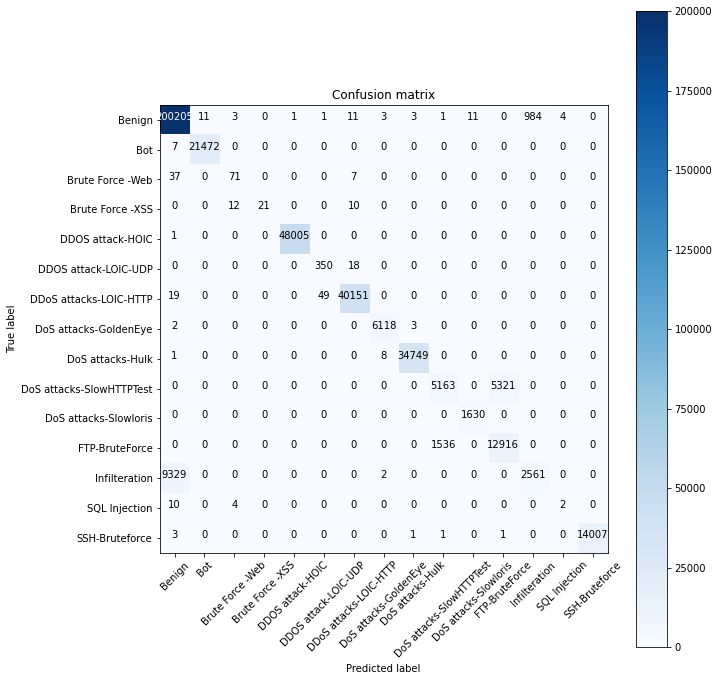

In [35]:
target_names = ["Class {}".format(i) for i in range(15)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))